# Strategy details

Calendar anomalies: Turn of the week (indices), turn of the month, quarter, and year

Many reasons are documents for the existence of this effect in the market:
1- Tax reduction using the capital loss
2- Window dressing by funds
3- Reinvestment in 401k and other mutual funds

To find further details regarding the mechanism and the ideas behind the following code, please refer to the following paper:

Link to the paper: https://ntnuopen.ntnu.no/ntnu-xmlui/bitstream/handle/11250/3023768/no.ntnu%3Ainspera%3A116271940%3A116280676.pdf?sequence=1&isAllowed=y

The following results show that these effect still exit in the market.
Still, further research is required to enhance these preliminary results



## Part 1: Load data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

symbols = pd.read_csv('../Symbols.csv', index_col=0)['US-Equity-1000'].dropna().tolist()[:1000]

def load_data(symbol):
    
    os.makedirs('data', exist_ok=True)

    direc = f"data/{symbol}.csv"
    if os.path.exists(direc):
        df = pd.read_csv(direc, index_col=0)
        df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
        return df
        
    df = yf.Ticker(symbol).history(start="2010-01-01", end="2024-11-30")
    df.to_csv(direc)

    return df
    
def process_data(df):
    
    try:
        df = df.copy()
        
        # Make it weekly
        df['return'] = df['Close'].pct_change()
        df['traded_volume'] = df['Volume'] * df['Close']
        
        # Find the last day of each month
        df['week'] = df.index.isocalendar().week
        df['month'] = df.index.month
        df['quarter'] = df.index.quarter
        df['year'] = df.index.year
        df = df.dropna()
        
        df['is_last_day_of_week'] = df['week'] != df['week'].shift(-1)
        df['is_last_day_of_month'] = df['month'] != df['month'].shift(-1)
        df['is_last_day_of_quarter'] = df['quarter'] != df['quarter'].shift(-1)
        df['is_last_day_of_year'] = df['year'] != df['year'].shift(-1)
        
        for t in [5, 21, 66, 252]:
            df[f"cum_return_{t}d"] = df['return'].rolling(t).sum()
            df[f"cum_return_{t}d_lagged_5"] = df[f"cum_return_{t}d"].shift(5)
            df[f"cum_traded_volume_{t}d"] = df['traded_volume'].rolling(t).sum()
            df[f"cum_traded_volume_{t}d_lagged_5"] = df[f"cum_traded_volume_{t}d"].shift(5)
        
        for col in ["month", "quarter", "year"]:
            df['is_last_day_of_' + col] = df['is_last_day_of_' + col].astype(int)
        
        df = df.drop(
            columns=[
                'week', 'month', 'quarter', 'year',
                'Dividends', 'Stock Splits',
                'High', 'Low', 'Open', 'Volume'
            ], 
            axis=1, 
            errors='ignore'
        )

        df = df.dropna()
    except Exception as e:
        print (f"Error processing {symbol}: {e}")
        return None
    
    return df

data_holder = {}
for symbol in symbols:
    data_holder[symbol] = process_data(load_data(symbol))

# Remove the ones that have no data
data_holder = {k: v for k, v in data_holder.items() if v is not None}

# Remove if the length of the data is less than 252
data_holder = {k: v for k, v in data_holder.items() if len(v) >= 252}
symbols = list(data_holder.keys())

print (f"Number of symbols: {len(symbols)}")

/home/vahid/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Number of symbols: 981


### Part2: Make 2d data for vectorized analysis, each row is a date, each column is a ticker

In [2]:
# Make 2D data, each row is a week, each column is a stock
annual_return_holder = []
quarter_return_holder = []
month_return_holder = []
return_holder = []
annual_traded_volume_holder = []

for symbol in symbols:
    return_holder.append(data_holder[symbol]['return'])
    annual_return_holder.append(data_holder[symbol]['cum_return_252d'])
    quarter_return_holder.append(data_holder[symbol]['cum_return_66d'])
    month_return_holder.append(data_holder[symbol]['cum_return_21d'])
    annual_traded_volume_holder.append(data_holder[symbol]['cum_traded_volume_252d'])

return_df = pd.concat(return_holder, axis=1)
return_df.columns = symbols

annual_return_df = pd.concat(annual_return_holder, axis=1)
annual_return_df.columns = symbols

quarter_return_df = pd.concat(quarter_return_holder, axis=1)
quarter_return_df.columns = symbols

month_return_df = pd.concat(month_return_holder, axis=1)
month_return_df.columns = symbols

annual_traded_volume_df = pd.concat(annual_traded_volume_holder, axis=1)
annual_traded_volume_df.columns = symbols


### Part 3: Performance reporter. 

We will focus on the average daily return and the t-statistic

In [3]:
def report_performance(returns_series):

  plt.plot(returns_series.cumsum())
  plt.xlabel("Date")
  plt.ylabel("Cumulative Return")
  plt.show()

  returns_series = returns_series.copy().dropna()

  # Print the average daily return and the t-statistic
  average_daily_return = returns_series.mean()
  t_statistic = returns_series.mean() / returns_series.std() * np.sqrt(len(returns_series))
  print (f"Average daily return: {average_daily_return:.4f}, T-statistic: {t_statistic:.2f}")

### Part 4: Turn of the year

Main idea: Buy the winners and sell the losers

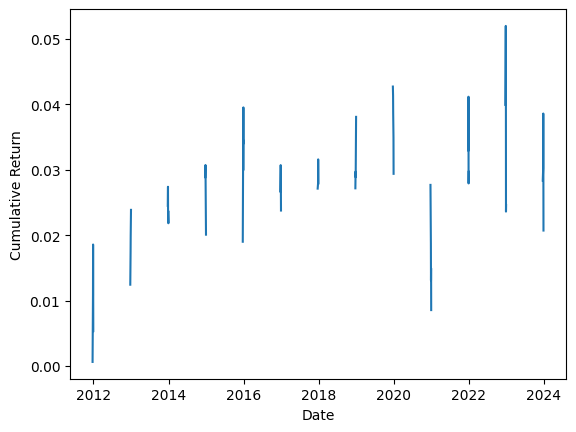

Average daily return: 0.0003, T-statistic: 0.35


In [18]:

# Turn of the year anomaly
# Each day, find the top N stocks with the highest and lowest returns
T = 5
N = 50

# Mask the top and bottom N stocks for each day
long_mask = annual_return_df.apply(lambda x: x >= x.nlargest(N).iloc[-1], axis=1)
short_mask = annual_return_df.apply(lambda x: x <= x.nsmallest(N).iloc[-1], axis=1)

long_mask_symbols = long_mask.apply(lambda x: x[x==1].index.tolist(), axis=1)
short_mask_symbols = short_mask.apply(lambda x: x[x==1].index.tolist(), axis=1)

portfolio_return = pd.DataFrame(np.nan, index=annual_return_df.index, columns=symbols)

first_df = data_holder[symbols[0]]
important_days = pd.DataFrame(index=first_df.index)
important_days["day_to_make_decision"] = first_df['is_last_day_of_year'].shift(-T) == 1
important_days["day_to_hold"] = 0

for i in range(T):
  important_days.loc[first_df["is_last_day_of_year"].shift(-i) != 0, "day_to_hold"] = 1

days_to_make_decision = important_days[important_days["day_to_make_decision"] != 0].index
days_to_hold = important_days[important_days["day_to_hold"] != 0].index

for decision_day in days_to_make_decision:

  symbols_to_long = long_mask_symbols.loc[decision_day]
  symbols_to_short = short_mask_symbols.loc[decision_day]

  for holding_day in days_to_hold[days_to_hold > decision_day][:T]:
    if pd.isna(holding_day):
      continue

    portfolio_return.loc[holding_day, symbols_to_long] = return_df.loc[holding_day, symbols_to_long]
    portfolio_return.loc[holding_day, symbols_to_short] = -return_df.loc[holding_day, symbols_to_short]

portfolio_return = portfolio_return.mean(axis=1, skipna=True)

report_performance(portfolio_return)

### Part 5: Turn of the quarter

Main idea: Buy the winners and sell the losers

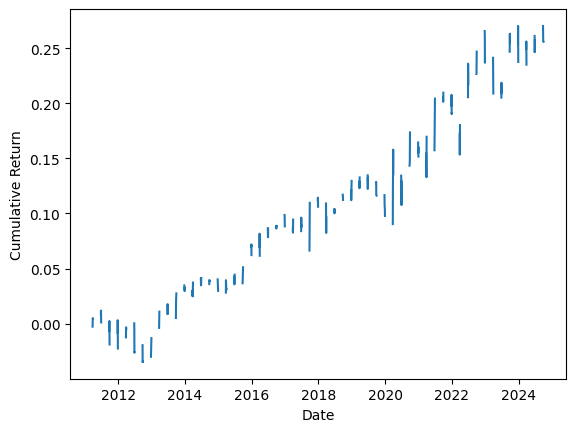

Average daily return: 0.0012, T-statistic: 1.61


In [15]:
# Turn of the quarter anomaly
# Each day, find the top N stocks with the highest and lowest returns
T = 4
N = 20

# Mask the top and bottom N stocks for each day
long_mask = annual_return_df.apply(lambda x: x >= x.nlargest(N).iloc[-1], axis=1)
short_mask = annual_return_df.apply(lambda x: x <= x.nsmallest(N).iloc[-1], axis=1)

long_mask_symbols = long_mask.apply(lambda x: x[x==1].index.tolist(), axis=1)
short_mask_symbols = short_mask.apply(lambda x: x[x==1].index.tolist(), axis=1)

portfolio_return = pd.DataFrame(np.nan, index=annual_return_df.index, columns=symbols)

first_df = data_holder[symbols[0]]
important_days = pd.DataFrame(index=first_df.index)
important_days["day_to_make_decision"] = first_df['is_last_day_of_quarter'].shift(-T) == 1
important_days["day_to_hold"] = 0

for i in range(T):
  important_days.loc[first_df["is_last_day_of_quarter"].shift(-i) != 0, "day_to_hold"] = 1

days_to_make_decision = important_days[important_days["day_to_make_decision"] != 0].index
days_to_hold = important_days[important_days["day_to_hold"] != 0].index

for decision_day in days_to_make_decision:

  symbols_to_long = long_mask_symbols.loc[decision_day]
  symbols_to_short = short_mask_symbols.loc[decision_day]

  for holding_day in days_to_hold[days_to_hold > decision_day][:T]:
    if pd.isna(holding_day):
      continue

    portfolio_return.loc[holding_day, symbols_to_long] = return_df.loc[holding_day, symbols_to_long]
    portfolio_return.loc[holding_day, symbols_to_short] = -return_df.loc[holding_day, symbols_to_short]

portfolio_return = portfolio_return.mean(axis=1, skipna=True)

report_performance(portfolio_return)

### Part 6: Turn of the month

Main idea: Buy the strong ones. Don't sell.

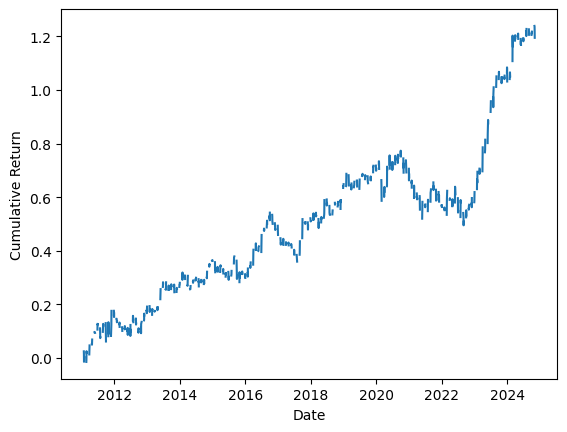

Average daily return: 0.0018, T-statistic: 2.59


In [16]:
# Turn of the month anomaly
# Each day, find the top N stocks with the highest and lowest returns
T = 4
N = 20

# Mask the top and bottom N stocks for each day
long_mask = month_return_df.apply(lambda x: x >= x.nlargest(N).iloc[-1], axis=1)
long_mask_symbols = long_mask.apply(lambda x: x[x==1].index.tolist(), axis=1)

portfolio_return = pd.DataFrame(np.nan, index=month_return_df.index, columns=symbols)

first_df = data_holder[symbols[0]]
important_days = pd.DataFrame(index=first_df.index)
important_days["day_to_make_decision"] = first_df['is_last_day_of_month'].shift(-T) == 1
important_days["day_to_hold"] = 0

for i in range(T):
  important_days.loc[first_df["is_last_day_of_month"].shift(-i) != 0, "day_to_hold"] = 1

days_to_make_decision = important_days[important_days["day_to_make_decision"] != 0].index
days_to_hold = important_days[important_days["day_to_hold"] != 0].index

for decision_day in days_to_make_decision:

  symbols_to_long = long_mask_symbols.loc[decision_day]

  for holding_day in days_to_hold[days_to_hold > decision_day][:T]:
    if pd.isna(holding_day):
      continue

    portfolio_return.loc[holding_day, symbols_to_long] = return_df.loc[holding_day, symbols_to_long]

portfolio_return = portfolio_return.mean(axis=1, skipna=True)

report_performance(portfolio_return)

### Part 7: Weekend effect in the vix index

The main idea: I have no clue, it seems to be there. Saw this somewhere in the internet, feel free to share your thoughts.

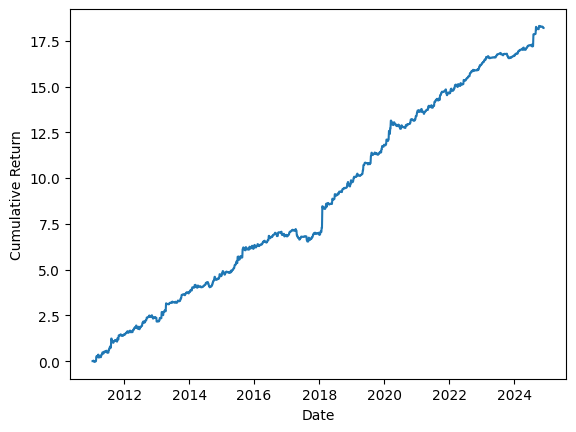

Average daily return: 0.0052, T-statistic: 6.64


In [12]:
vix = process_data(load_data("^VIX"))
vix['is_monday'] = vix['is_last_day_of_week'].shift(1)

portfolio_return = vix['return'].mul(vix['is_monday'])

report_performance(portfolio_return)

### Final thoughts:

1- Transaction costs are not considered, but given the >4 day holding period, it shouldn't affect the performance much.

2- There's a huge universe selection bias here. But since the signals are long/short, the preliminary results are not that bad. Better universe simulation is needed to further verify the signals.

3- I'm pretty sure the results could be further improved by adding a touch of machine learning, but that goes into the proprietary realm of the business.